# Loan Recommendation System
## POC - Proof Of Concept

In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
from pyspark.sql.functions import mean
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.ml import Pipeline 

In [3]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "2g").getOrCreate()

In [6]:
spark

In [7]:
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



- Id: Likely a unique identifier for each data point.
- AccountID: Unique identifier for an account (possibly borrower).
- <h4>Loan-related features: </h4> 
    -> Number_Of_Loans_Granted__c: Number of loans granted to the account.
    -> Num_Of_Loans_Paid__c: Number of loans paid by the account.
    -> Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    -> Total_Repayments__c: Total amount repaid by the account.
    -> Amount: Loan amount requested.
    -> Term_in_Weeks__c: Loan term in weeks.
    -> Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
- <h4>Borrower-related features: </h4>    -> 
StageName: Current stage of the loan application (e.g., application, approved, rejected).    -> 
Applicant Age: Age of the loan applicant    -> .
summary_income: Summary of applicant's incom    -> e.
summary_income_cv: Coefficient of variation of applicant's inco- <h4>me.
Location-related feat </h4>u    -> res:
city: City of the appli    -> cant.
state: State of the appl    -> icant.
Country: Country of the ap

- <h4>Additional features:</h4>    -> 
userId: Unique identifier for a user Account Id in Numericr).    -> 
loanId: Unique identifier for a lo (Id or loanId in Numeric)an    -> .
counFeature related to the Ratings of the Loansnt    -> s.
LoanIdFormat: Format of the loan(Created LoanId using Clusters)nce).plicant.

In [8]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|   500|                 10|              Weekly|    3|
|           1|   700|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   900|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



In [9]:
loans_df.select(["userId","LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|      LoanIdFormat|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            559151|            559151|            559151|           559151|             559151|                    559151|              559151|
|   mean|24735.774815747445| 4.527168868516734|1.6699120631099649|823.7755990778877| 7.0393507299459355|        11.901447015206983|   11.85676856519974|
| stddev|15283.929730968575|2.7984778294163046|0.8954014280676444|766.2637755312196| 3.9631196080149786|         8.154409123854771|   8.273339043377455|
|    min|                 1|                 1|                 0|              10

### Aggregating the loans per user (getting all loans for each user user)¶

In [68]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("LoanIdFormat").alias("loans"))

In [69]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

In [10]:
loans_df.show(vertical=True)

-RECORD 0------------------------------------------
 Id                         | 0062x00000DsEQcAAN   
 AccountID                  | 0010K00001ayVHPQA2   
 Number_Of_Loans_Granted__c | 27                   
 Num_Of_Loans_Paid__c       | 27                   
 Purpose_of_Loan__c         | Furniture or Appl... 
 Total_Repayments__c        | 10                   
 Amount                     | 500                  
 Term_in_Weeks__c           | 10.143               
 Payment_Frequency__c       | Weekly               
 StageName                  | Loan Paid            
 Applicant Age              | 55                   
 summary_income             | 2166.67              
 summary_income_cv          | 5750.7               
 city                       | Jimboomba            
 state                      | QLD                  
 Country                    | Australia            
 userId                     | 1                    
 loanId                     | 385865               
 count      

In [11]:
hist_data  = loans_df.toPandas()

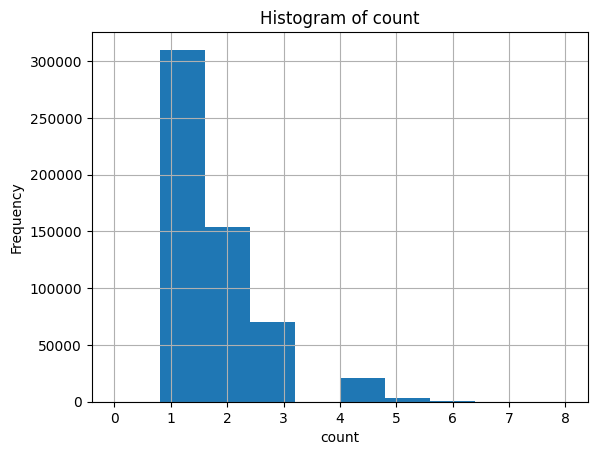

In [12]:
hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

In [13]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 20
Number of unique Loan Id: 407389


In [14]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

# Count the number of unique users
# tmp = ratings_df.select('movieId').distinct().count()
# print(f"Number of unique movies: {tmp}")

Number of unique users: 59158


In [15]:
print('Distinct values of count:')
print(sorted(loans_df.select('count').distinct().collect()))

Distinct values of count:
[Row(count=0), Row(count=1), Row(count=2), Row(count=3), Row(count=4), Row(count=5), Row(count=6), Row(count=7), Row(count=8)]


In [16]:
# distinct values of the rating
loans_df.select("count").distinct().show()

+-----+
|count|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    8|
|    7|
|    2|
|    0|
+-----+



========================================================================================================

Converting the dataset into train test and validation split.

In [17]:
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    3|   500|
|           1|    3|   700|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   900|
|           1|    3|  1000|
|           1|    3|  1000|
+------------+-----+------+
only showing top 10 rows



In [18]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [19]:
validation.select(["userId","loanId","LoanIdFormat","count","Amount","Total_Repayments__c"]).show()

+------+------+------------+-----+------+-------------------+
|userId|loanId|LoanIdFormat|count|Amount|Total_Repayments__c|
+------+------+------------+-----+------+-------------------+
| 23515|    37|           1|    3|   700|                 10|
| 23722|    52|           1|    1|   800|                 10|
| 23844|    56|           1|    1|   700|                 10|
| 23601|    65|           1|    1|   600|                 10|
|   186|    99|           1|    1|   350|                 10|
| 24458|   113|           1|    2|   450|                 10|
| 24289|   184|           1|    2|   200|                 10|
| 24831|   252|           1|    1|  1000|                 10|
| 25043|   253|           1|    2|   400|                 10|
| 23833|   258|           1|    3|   550|                 10|
|    95|   268|           1|    1|   500|                 10|
| 24975|   289|           1|    2|   200|                 10|
| 23319|   327|           1|    2|   250|                 10|
| 23546|

In [20]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [21]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)
            
            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))
            
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [22]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.012937124622129256
8 latent factors and regularization = 0.01: validation RMSE is 0.050933549062445974
8 latent factors and regularization = 0.05: validation RMSE is 0.07633936701223833
8 latent factors and regularization = 0.1: validation RMSE is 0.09729289649130228
8 latent factors and regularization = 0.2: validation RMSE is 0.19778619772391207
10 latent factors and regularization = 0.001: validation RMSE is 0.04959422859404009
10 latent factors and regularization = 0.01: validation RMSE is 0.02166912112830898
10 latent factors and regularization = 0.05: validation RMSE is 0.06139648709525339
10 latent factors and regularization = 0.1: validation RMSE is 0.09342881980157451
10 latent factors and regularization = 0.2: validation RMSE is 0.1984996700104884
20 latent factors and regularization = 0.001: validation RMSE is 0.07537289705585688
20 latent factors and regularization = 0.01: validation RMSE is 0.051490010143514

In [23]:
#OLD :  40 latent factors and regularization = 0.001
#NEW: The best model has 8 latent factors and regularization = 0.001

## Predicting the results from validation data

In [24]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [25]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "LoanIdFormat", "prediction").show(20)

+------+------+-----+------------+----------+
|userId|loanId|count|LoanIdFormat|prediction|
+------+------+-----+------------+----------+
|    10| 68823|    4|           1| 3.9756207|
|    10|196969|    4|           1| 3.9756207|
|    10|270162|    4|           1| 3.9756207|
|    10|371513|    4|           1| 3.9756207|
|    10|  4994|    4|           6| 3.9778917|
|    10| 13864|    4|           6| 3.9778917|
+------+------+-----+------------+----------+



In [26]:
predictions.count()

111461

In [27]:
validation.count()

111965

## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [28]:
 
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))


Root Mean Squared Error (RMSE) = 0.012937124622129256


## Recommendation of N users

In [29]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [30]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [31]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



## ALS Model Evaluation

In [32]:
from pyspark.sql.functions import col, expr

In [33]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'LoanIdFormat'], 'inner')

In [34]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(LoanIdFormat) as true_positives'))

In [35]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(LoanIdFormat) as relevant'))

In [36]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [37]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [38]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [39]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [40]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.8412396212810629
Overall Recall: 1.8412396212810629
Overall F1-score: 1.8412396212810802


## User Factors and Item Factors to calculate the cosine Similarity

In [41]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [42]:
userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [43]:
userFactors.select(["id","Features"]).show(10,truncate=False)

+---+------------------------------------------------------------------------------------------------+
|id |Features                                                                                        |
+---+------------------------------------------------------------------------------------------------+
|10 |[0.9581449, 3.192441, 4.54543, 7.3011003, 2.7185254, 0.12014717, 0.001578205, 0.1461944]        |
|20 |[0.22901839, 0.8187388, 1.1340045, 1.8232843, 0.6648415, 0.03510927, 0.0, 0.0307664]            |
|30 |[0.2609801, 0.7707764, 1.1288944, 1.8289481, 0.7079715, 0.017045103, 0.005176256, 0.042354356]  |
|40 |[0.22901839, 0.8187388, 1.1340045, 1.8232843, 0.6648415, 0.03510927, 0.0, 0.0307664]            |
|50 |[0.25470343, 0.78115815, 1.1251354, 1.827645, 0.70651823, 0.01652176, 0.0018497412, 0.032913897]|
|60 |[0.23470937, 0.8067877, 1.1359364, 1.8243833, 0.6729415, 0.032506987, 0.0, 0.0342161]           |
|70 |[0.22901839, 0.8187388, 1.1340045, 1.8232843, 0.6648415, 0.03510927,

## Calculate cosine similarity:

### user-User Cosine Similarity code 

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [44]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [45]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 10 and 20: 0.9999287995585844


### User-Item Cosine Similarity code

In [46]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")


Cosine similarity between users 10 and 1: 0.9999504672265569


###  Cosine Similarity of user 10 with all Loans

In [47]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
    
    
    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [49]:
import operator

In [50]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 1, 'CosineSimilarity': 0.9999504672265569},
 {'userID': 10, 'LoanId': 6, 'CosineSimilarity': 0.9999287994545193},
 {'userID': 10, 'LoanId': 7, 'CosineSimilarity': 0.9994599574025389},
 {'userID': 10, 'LoanId': 9, 'CosineSimilarity': 0.999299320206466},
 {'userID': 10, 'LoanId': 4, 'CosineSimilarity': 0.9991921128223066},
 {'userID': 10, 'LoanId': 3, 'CosineSimilarity': 0.9991060019277567},
 {'userID': 10, 'LoanId': 5, 'CosineSimilarity': 0.9990450845465627},
 {'userID': 10, 'LoanId': 16, 'CosineSimilarity': 0.9990292505660257},
 {'userID': 10, 'LoanId': 11, 'CosineSimilarity': 0.998938687097469},
 {'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.9989019170662072},
 {'userID': 10, 'LoanId': 14, 'CosineSimilarity': 0.998890172705074},
 {'userID': 10, 'LoanId': 2, 'CosineSimilarity': 0.9987753274611886},
 {'userID': 10, 'LoanId': 12, 'CosineSimilarity': 0.9985581609775114},
 {'userID': 10, 'LoanId': 19, 'CosineSimilarity': 0.9984063298037468},
 {'userID': 10, 'L

##  Calculate centered cosine similarity:

In [51]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)
    
    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])
    
    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))
    
    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [52]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9998643610135634


### User-Item Centerd Cosine Similarity code

In [53]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9999047977332826


### Cosine Similarity of user 10 with all Loans

In [54]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
    
    
    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [55]:
# Import the operator module
import operator

In [56]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9999047977332826},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9998643608054378},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9989621563479066},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9986758500514171},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9984685643194371},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9983618795125254},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9981485391638203},
 {'userID': 10, 'LoanId': 16, 'CenteredSimilarity': 0.9981087104726665},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9980127544575598},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.9978739101759401},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.99786344501052},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.997640716810169},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9974189179134068},
 {'userID': 10, 'LoanId': 19, 'CenteredSimilarity': 0.996908928

In [57]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9999047977332826},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.997640716810169},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9983618795125254},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9984685643194371},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9981485391638203},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9998643608054378},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9989621563479066},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.99786344501052},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9986758500514171},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9918849075660491},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9980127544575598},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9974189179134068},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.3485126929718231},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.997873910

In [60]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [61]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [62]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.0018413013882107206 hours


In [63]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [70]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [71]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [72]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [73]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [76]:
k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.7026
